In [207]:
"""
imports
"""
import numpy as np                      # Math
import matplotlib.pyplot as plt         # Plotting
import matplotlib as mpl                # Matplotlib
from ipywidgets import interact         # Interactivity
from scipy.optimize import fsolve       # Numerically solve equations
import ipywidgets as widgets            # Widgets
from matplotlib import colors

%matplotlib widget

In [208]:
"""
General functions
"""


def euler_int(start, f, dt, steps, *args, **kwargs):
    """
    function implementing the euler method for integrating a function with N variables
    """
    eul = np.zeros((steps, len(start)))
    eul[0] = start
    
    for i in range(steps-1):
        eul[i+1] = eul[i] + dt * f(*eul[i], *args, **kwargs)
    
    return eul.T # return the transpose so we can use X, Y, Z = euler_int( ... )


def normalize(x):
    N = np.hypot(*x)
    N[N == 0] = 1
    for i in range(len(x)):
        x[i] = x[i] / N
    return x


def get_color_range(N, c_map_name):
    """
    create a range of N discrete colors from a matplotlib colormap
    """
    cmap = mpl.cm.get_cmap(c_map_name)
    return [cmap(i) for i in np.linspace(0, 1, N)]

In [178]:
"""
Functions related to paths from a set of functions
"""

def calc_arrow_pos(pos, dirs, euls, arrow_step):
    # calculate the arrow position and directions
    for i in range(10, len(pos[0]), arrow_step):
        for p, d, e in zip(pos, dirs, euls):
            p[i] = e[i]
            d[i] = e[i+2] - e[i]


def circle_start_pos(radii, n_points):
    # we have starting points on 2 circles, an inside circle with small
    # radius and an outside one with big radius
    return [(r * np.cos(2*np.pi / n_points * i), 
             r * np.sin(2*np.pi / n_points * i)) for r in radii for i in range(n_points)]


# calculate and draw paths
def plot_paths(ax, start_locs, func, steps, size, *args,
               arrow_step=35, arrows=True, color='red', cmap=None, line_style='solid'):
    """
    A function that plots the paths the vectorspace and adds arrows
    onto them. We have a list with locations where we want to start
    calculating the path from. We then use euler integration to find
    the x and y values we need to plot. Next we set a range and skip
    a lot of values each iteration. An arrow per point would b-e too
    much. Finally we normalize the vectors and plot them.
    """
    
    # enumerate over all starting locations in the X, Y plane
    for n, params in enumerate(start_locs):
        dim = len(start_locs[0])
        
        # plot the paths
        euler = euler_int(params, func, steps, size, *args)
        ax.plot(*euler, color=cmap[n] if cmap else color, linestyle=line_style,
                label=f'($X_0$, $Y_0$)=({np.around(params[0], 2)}, {np.around(params[1], 2)})')
        
        if arrows:
            # arrays to plot the arrows
            arrays = [np.zeros(len(euler[0])-2) for i in range(dim*2)]
            pos = [np.zeros(len(euler[0])-2) for i in range(dim)]
            dirs = [np.zeros(len(euler[0])-2) for i in range(dim)]
            calc_arrow_pos(pos, dirs, euler, arrow_step)

            # we normalize the vectors so they all have the same length
            normal_vec = normalize(dirs)

            # using quiver we can easily plot all arrows at once. This is
            # faster than seperate arrow calls.
            ax.quiver(*pos, *normal_vec, color=cmap[n] if cmap else color, 
                      width=0.015, scale=60, headwidth=15, headlength=15, minlength=1)

In [179]:
"""
Functions specific to the rayleigh osc
"""

def Rayleigh(X, V, a):
    def X_prime(V):
        return V


    def V_prime(X, V, a):
        return -X - (a*(V**3) - V)
    return np.array([X_prime(V), V_prime(X, V, a)])


def plot_rayleigh(ax, a=1, steps=0.01, size=1000, title=None):
    start_coords = circle_start_pos([0.075, 2], 6)
    cmap = get_color_range(len(start_coords), 'winter')
    plot_paths(ax, start_coords, Rayleigh, steps, size, a, cmap=cmap, arrow_step=75)

    # draw point to denote an unstable equilibrium
    ax.plot(0, 0, label = 'Unstable equilibrium point', zorder=10,
                 marker='o', markerfacecolor='white', linestyle='none', color='Black')

    ax.set_xlabel('X')
    ax.set_ylabel('V')
    ax.set_title(title if title else f'a = {a}')

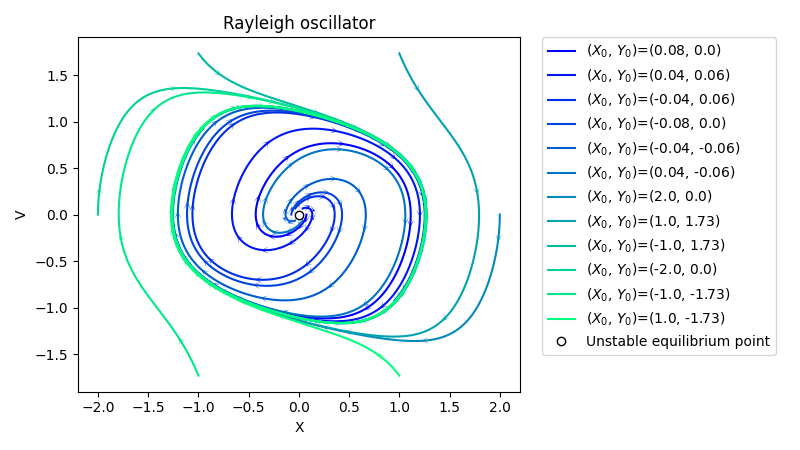

In [180]:
"""
Plot the rayleigh oscillator
"""


f1 = plt.figure(figsize=(8, 4.5))
axes1 = f1.add_subplot()
plot_rayleigh(axes1, 1, title='Rayleigh oscillator')
axes1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
f1.tight_layout()
plt.show()

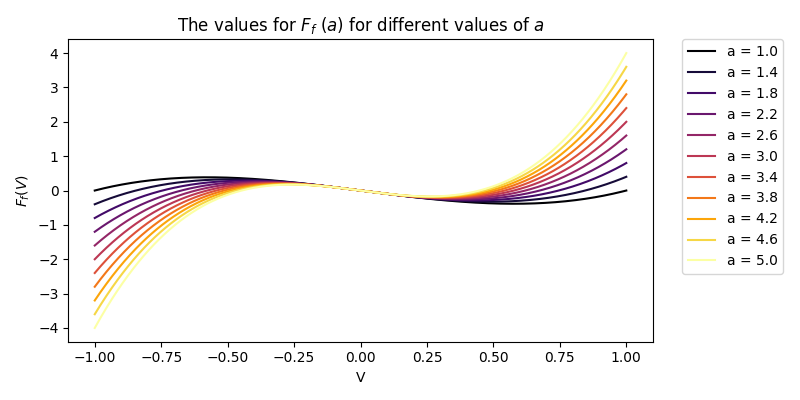

In [181]:
"""
Examine how F_f changes if the constant a changes
"""


def F_f(V, a):
    return a * V**3 - V


def plot_F_range(ax, N, x_min=1, x_max=5, cmap_name='inferno'):
    V = np.linspace(-1, 1, 1000)
    a_range = np.linspace(x_min, x_max, N)
    c_range = get_color_range(N, cmap_name)
    for a, c in zip(a_range, c_range):
        F = F_f(V, a)
        ax.plot(V, F, label=f'a = {np.around(a, 2)}', c=c)
        
    ax.set_xlabel('V')
    ax.set_ylabel('$F_f(V)$')
    ax.set_title('The values for $F_f$ $(a)$ for different values of $a$')
    axes2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., ncol=N//10)
    f2.tight_layout()
        

f2 = plt.figure(figsize=(8, 4.))
axes2 = f2.add_subplot()
plot_F_range(axes2, 11)
plt.show()

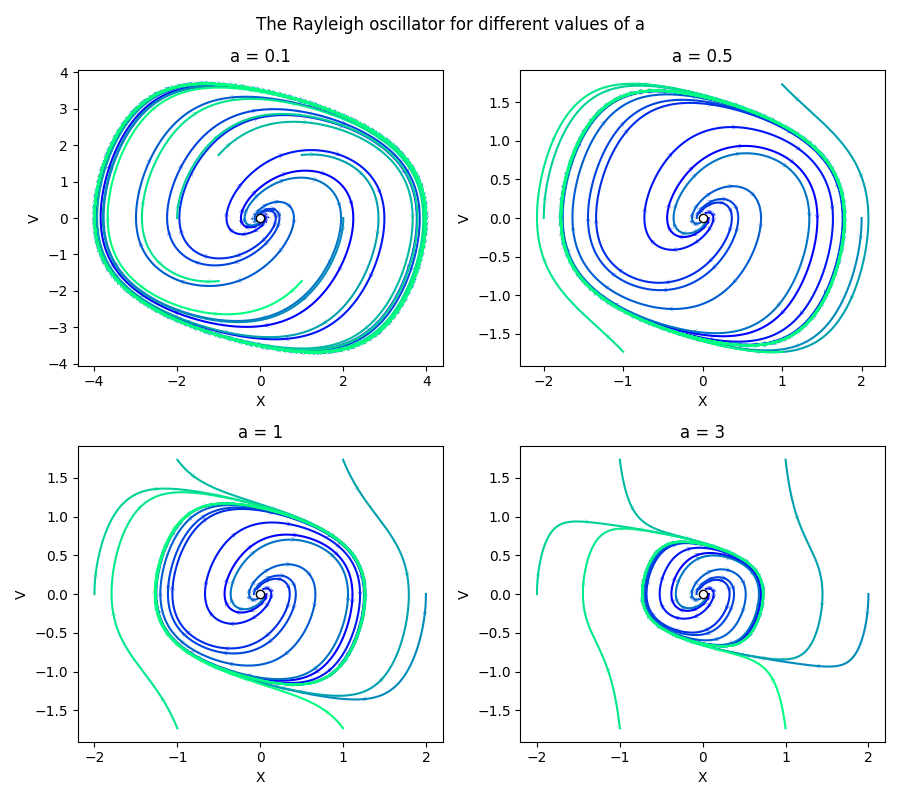

In [182]:
"""
Examine how the rayleigh oscillator changes if the constant a changes
"""

# init subplots
f3, axes3 = plt.subplots(nrows=2, ncols=2, figsize=(9, 8))

# plot for different values of a
plot_rayleigh(axes3[0][0], 0.1, size=5000)
plot_rayleigh(axes3[0][1], 0.5, size=3000)
plot_rayleigh(axes3[1][0], 1)
plot_rayleigh(axes3[1][1], 3)

f3.suptitle("The Rayleigh oscillator for different values of a")
f3.tight_layout()

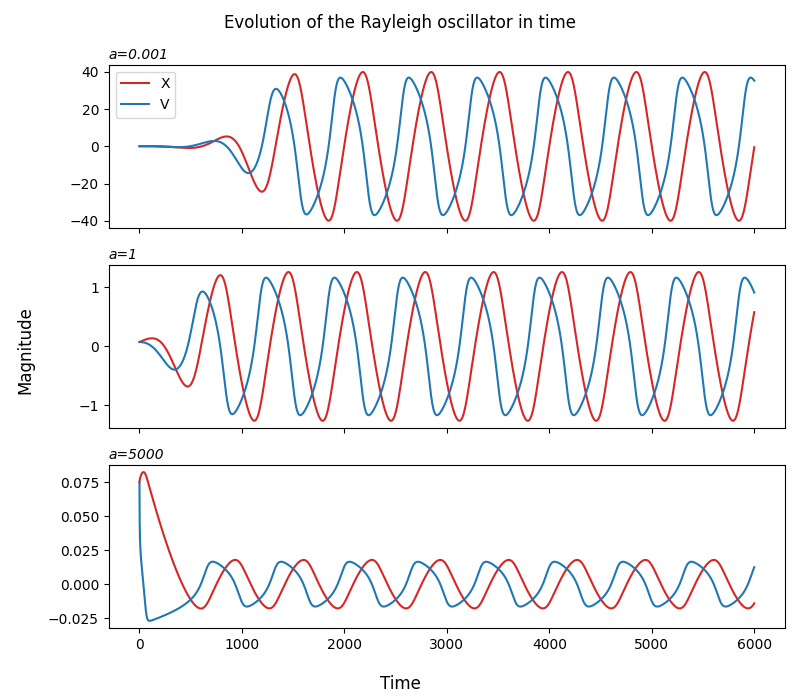

In [184]:
"""
How do V and X evolve over time for different values of a
"""


def plot_in_time(ax, start_points, func, steps, n_steps, labels, colors, *args):
    time = np.array(range(n_steps))
    euler = euler_int(start_points, func, steps, n_steps, *args)
    
    for eul, label, c in zip(euler, labels, colors):
        ax.plot(time, eul, label=label, c=c)
        

def add_cst_descriptors(ax, arg):
    y_min, y_max = ax.get_ylim()
    y_text = y_max / 10
    ax.set_xlabel(f'a={arg}', loc='left', fontsize='medium', fontstyle='italic', linespacing=20)
    ax.xaxis.set_label_position("top")


f4, axes4 = plt.subplots(nrows=3, ncols=1, figsize=(8, 7), sharex=True)
for n, a in enumerate([0.001, 1, 5000]):
    plot_in_time(axes4[n], [0.075, 0.075], Rayleigh, 0.01, 6000, ['X', 'V'],['tab:red', 'tab:blue'], a)
    add_cst_descriptors(axes4[n], a)

f4.supxlabel('Time')
f4.supylabel('Magnitude')
axes4[0].legend(loc="upper left")
f4.suptitle("Evolution of the Rayleigh oscillator in time")
f4.tight_layout()

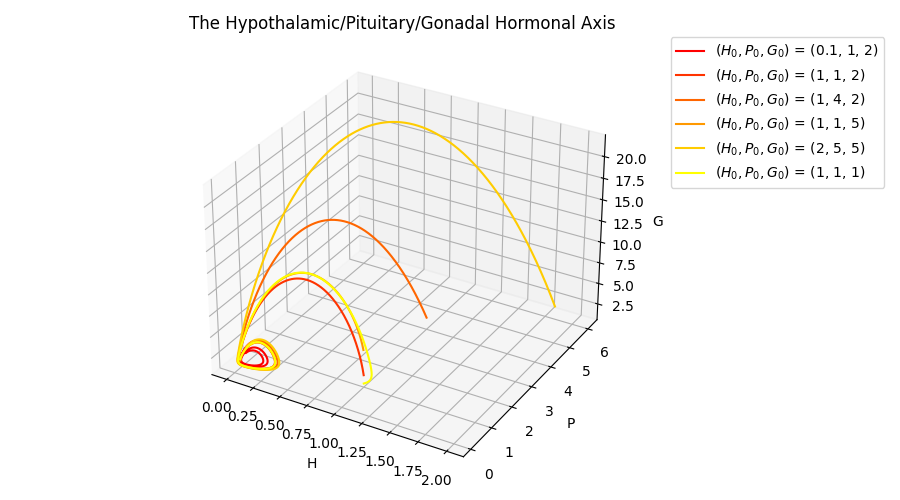

In [185]:
"""
The Hypothalamic/Pituitary/Gonadal Hormonal Axis
"""

def HPG(H, P, G, k=0.2, n=9):
    def H_prime(H, G, k, n):
        return 1/(1 + G**n) - k*H


    def P_prime(H, P, k):
        return H - k*P


    def G_prime(P, G, k):
        return P - k*G
    
    return np.array([H_prime(H, G, k, n), P_prime(H, P, k), G_prime(P, G, k)])


def plot_paths_3D(ax, start_locs, func, steps, size, *args, color='red', cmap=None, line_style='solid'):
    for n, start in enumerate(start_locs):
        dim = len(start_locs[0])
        
        # plot the paths
        euler = euler_int(start, func, steps, size, *args)
        ax.plot(*euler, color=cmap[n] if cmap else color, linestyle=line_style,
               label='$(H_0, P_0, G_0)$ = ({}, {}, {})'.format(*start_locs[n]))


def plot_hormonal_3D(ax, steps=0.01, size=5000):
    start_pos = [(0.1, 1, 2), (1, 1, 2), (1, 4, 2), (1, 1, 5), (2, 5, 5), (1, 1, 1)]
    plot_paths_3D(ax, start_pos, HPG, steps, size, 
                  cmap=get_color_range(len(start_pos), 'autumn'))
    
    ax.set_xlabel('H')
    ax.set_ylabel('P')
    ax.set_zlabel('G')
    ax.set_title('The Hypothalamic/Pituitary/Gonadal Hormonal Axis')
    

f5 = plt.figure(figsize=(9, 5))
axes5 = f5.add_subplot(projection='3d')
plot_hormonal_3D(axes5)
axes5.legend(bbox_to_anchor=(1.1, 1), loc="upper left", borderaxespad=0., ncol=1)
f5.tight_layout()
plt.show()

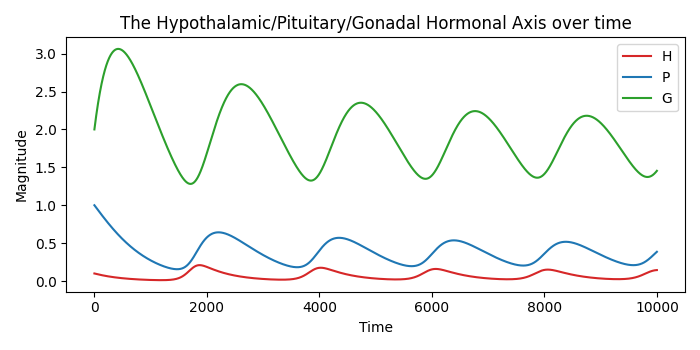

In [186]:
"""
The Hypothalamic/Pituitary/Gonadal Hormonal Axis time evolution
"""

f6, axes6 = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
plot_in_time(axes6, (0.1, 1, 2), HPG, 0.01, 10000, ['H', 'P', 'G'], ['tab:red', 'tab:blue', 'tab:green'])
axes6.legend()
axes6.set_title('The Hypothalamic/Pituitary/Gonadal Hormonal Axis over time')
axes6.set_xlabel('Time')
axes6.set_ylabel('Magnitude')
f6.tight_layout()
plt.show()

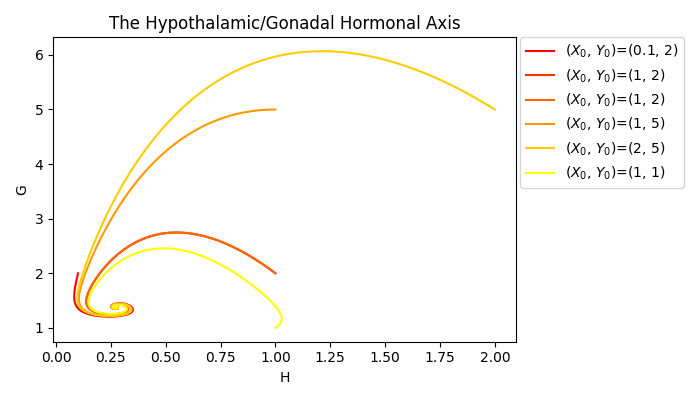

In [187]:
def HP(H, G, k=0.2, n=9):
    def H_prime2(H, G, k, n):
        return 1/(1 + G**n) - k*H


    def G_prime2(H, G, k):
        return H - k*G
    
    return np.array([H_prime2(H, G, k, n), G_prime2(H, G, k)])


def plot_hormonal_2D(ax, steps=0.01, size=5000):
    start_pos = [(0.1, 2), (1, 2), (1, 2), (1, 5), (2, 5), (1, 1)]
    plot_paths(ax, start_pos, HP, steps, size, arrows=False, 
                  cmap=get_color_range(len(start_pos), 'autumn'))
    
    ax.set_xlabel('H')
    ax.set_ylabel('G')
    ax.set_title('The Hypothalamic/Gonadal Hormonal Axis')
    

f7 = plt.figure(figsize=(7, 4))
axes7 = f7.add_subplot()
plot_hormonal_2D(axes7)
axes7.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0., ncol=1)
f7.tight_layout()
plt.show()

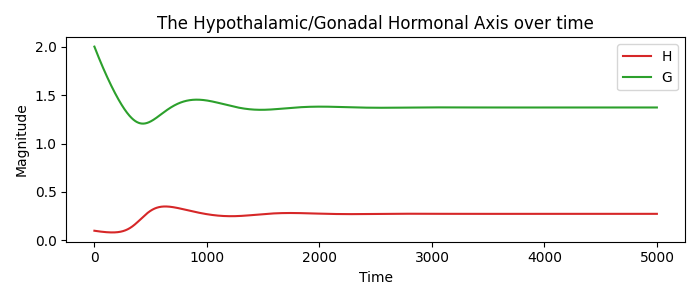

In [188]:
f8, axes8 = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))
plot_in_time(axes8, (0.1, 2), HP, 0.01, 5000, ['H', 'G'], ['tab:red', 'tab:green'])
axes8.legend()
axes8.set_title('The Hypothalamic/Gonadal Hormonal Axis over time')
axes8.set_xlabel('Time')
axes8.set_ylabel('Magnitude')
f8.tight_layout()
plt.show()

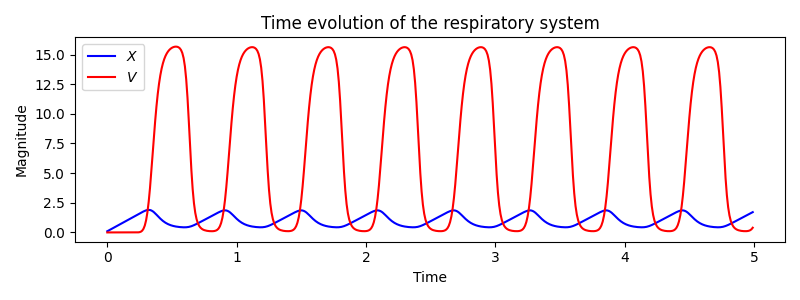

In [230]:
def CO2(X, X_old, L=6, Vmax=16, n=6):
    def X_prime(X, X_old, L, Vmax, n):
        return L - ((Vmax * X_old**n) / (1 + X_old**n))*X


    def V_CO2(X_old, Vmax, n):
        return (Vmax * X_old**n) / (1 + X_old**n)
    
    return np.array([X_prime(X, X_old, L, Vmax, n), V_CO2(X_old, Vmax, n)])


def euler_int_time_dep(start, f, dt=0.01, tau=0.2, steps=500, *args, **kwargs):
    dsteps = tau / dt
    x = np.zeros((steps, 2))
    x[0] = start
    
    for i in range(steps-1):
        X_old = 0 if int(i - dsteps) < 0 else x[int(i - dsteps)][0]
        results = f(x[i][0], X_old, *args, **kwargs)
        
        x[i+1][0] = x[i][0] + dt*results[0]  # X_prime
        x[i+1][1] = results[1]  # V_CO2
        
    return x.T


def time_plot_CO2(ax, start, dt=0.01, steps=500):
    X_t, V_t = euler_int_time_dep(start, CO2)
    t = np.array([i for i in range(len(X_t))]) * dt
    axes9.plot(t, X_t, label='$X$', c='blue')
    axes9.plot(t, V_t, label='$V$', c='red')
    axes9.set_xlabel("Time")
    axes9.set_ylabel("Magnitude")
    axes9.set_title("Time evolution of the respiratory system")
    axes9.legend()


f9, axes9 = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
time_plot_CO2(axes9, (0.1, 0))
f9.tight_layout()
plt.show()

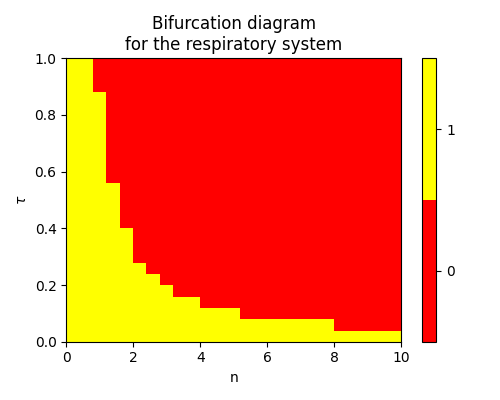

In [243]:
def has_oscillations(X_t):
    return 1 if (max(X_t[len(X_t)-100: len(X_t)]) - min(X_t[len(X_t)-100: len(X_t)])) <= 0.1 else 0


def create_matrix(grid, dim):
    a = np.zeros((dim, dim))
    x, y = grid
    for i in range(dim):
        for j in range(dim):
            X_t, V_t = euler_int_time_dep(start, CO2, n=x[i][j], tau=y[i][j])
            a[i][j] = has_oscillations(X_t)
    return a


def plot_2D_CO2(ax):
    dim = 25
    n_range = np.linspace(0, 10, dim)
    tau_range = np.linspace(0, 1, dim)
    nt_grid = np.meshgrid(n_range, tau_range)
    
    bounds=[-0.5, 0.5, 1.5]
    cmap = mpl.cm.get_cmap('autumn')
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    img = ax.imshow(create_matrix(nt_grid, dim), interpolation='nearest', origin='lower', aspect='auto', cmap=cmap, norm=norm, extent=[0, 10, 0, 1])
    plt.colorbar(img, boundaries=bounds, ticks=[0, 1])
    
    ax.set_xlabel('n')
    ax.set_ylabel(r'$\tau$')
    ax.set_title('Bifurcation diagram\nfor the respiratory system')


f10, axes10 = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
plot_2D_CO2(axes10)
f10.tight_layout()
plt.show()